<a href="https://colab.research.google.com/github/GokayToga/ThermalNet/blob/main/ThermalNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ThermalNet by GBC&Co.**

## Libraries

In [1]:
!pip install PyDrive
!pip install gdown
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cpu
!pip install loguru
!pip install pytorch_lightning
!pip pip install matplotlib networkx

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu124
    Uninstalling torch-2.5.1+cu124:
      Successfully uninstalled torch-2.5.1+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu124
    Uninstalling torchvision-0.20.1+cu124:
      Successfully uninstalled torchvision-0.20.1+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.0.1+cpu which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.2 MB/s e

In [2]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.8 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#from kornia.feature import LoFTR

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
from kornia.feature import LoFTR

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing & Augmentation

### Data Preprocessing

#### 1. Define the Dataset Class

This section involves defining the ThermalRGBDataset class, which handles the loading and preprocessing of RGB and thermal image pairs. Key points:
- _load_pairs(): Loads pairs of thermal and visible images by matching filenames.
- \_\_len\_\_: Returns the total number of paired images in the dataset.
- \_\_getitem\_\_: Loads and preprocesses RGB and thermal images by resizing, normalizing, and applying transformations.


In [ ]:
# Define rgb_augmentation
def rgb_augmentation(pil_image):
    """
    Apply random augmentations to an RGB image using torchvision transforms.
    """
    augmentation = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
    ])
    return augmentation(pil_image)

# Define add_noise
def add_noise(image):
    """
    Add random Gaussian noise to a thermal image.
    """
    mean = 0
    stddev = 0.05
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Your Dataset class and DataLoader logic remain unchanged

class ThermalRGBDataset(Dataset):
    def __init__(self, base_dir, condition, img_size=(640, 480), augment=False, transform=None):
        """
        Initialize the dataset.

        Args:
            base_dir (str): Path to the dataset root directory.
            condition (str): 'cloudy' or 'sunny'.
            img_size (tuple): Target image size (width, height).
            augment (bool): Whether to apply augmentations.
            transform (callable): Additional transforms to apply.
        """
        self.base_dir = base_dir
        self.condition = condition
        self.img_size = img_size
        self.augment = augment
        self.transform = transform
        self.pairs = self._load_pairs()

    def _load_pairs(self):
        """
        Load paired thermal and visible images.
        """
        pairs = []
        condition_path = os.path.join(self.base_dir, self.condition)
        scenes = [os.path.join(condition_path, scene) for scene in os.listdir(condition_path) if scene.startswith("scene")]
        for scene in scenes:
            thermal_path = os.path.join(scene, "thermal/images")
            visible_path = os.path.join(scene, "visible/images")

            thermal_files = sorted(os.listdir(thermal_path))
            visible_files = sorted(os.listdir(visible_path))
            for thermal, visible in zip(thermal_files, visible_files):
                pairs.append((os.path.join(thermal_path, thermal), os.path.join(visible_path, visible)))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        """
        Load and preprocess a single pair of images.
        """
        thermal_path, visible_path = self.pairs[idx]

        # Load images
        thermal_img = cv2.imread(thermal_path, cv2.IMREAD_GRAYSCALE)
        visible_img = cv2.imread(visible_path)

        # Resize images
        thermal_img = cv2.resize(thermal_img, self.img_size)
        visible_img = cv2.resize(visible_img, self.img_size)

        # Normalize images
        thermal_img = thermal_img / 255.0
        visible_img = visible_img / 255.0

        # Apply augmentations if specified
        if self.augment:
            # --- Suggested Changes ---
            # Convert visible image to a PyTorch tensor before augmentations
            visible_img = transforms.ToTensor()(visible_img)
            # --- End of Suggested Changes ---

            # Augment visible (RGB) image
            visible_img = rgb_augmentation(transforms.ToPILImage()(visible_img))
            visible_img = np.array(visible_img) / 255.0  # Convert back to numpy

            # Augment thermal image
            thermal_img = add_noise(thermal_img)

        # Apply transforms if provided
        if self.transform:
            visible_img = self.transform(visible_img)
            thermal_img = self.transform(thermal_img)

        # Convert thermal image to tensor and add a channel dimension
        thermal_img = torch.tensor(thermal_img, dtype=torch.float32).unsqueeze(0)

        return visible_img, thermal_img

#### 2. The Visualization Function

This part defines a helper function visualize_pair() to display paired RGB and thermal images side by side.
- Converts PyTorch tensors back into images.
- Visualizes RGB in color and thermal images using a heatmap (e.g., hot colormap).

Processing condition: sunny
Condition: sunny, Visible Image Shape: torch.Size([8, 480, 640, 3]), Thermal Image Shape: torch.Size([8, 1, 480, 640])


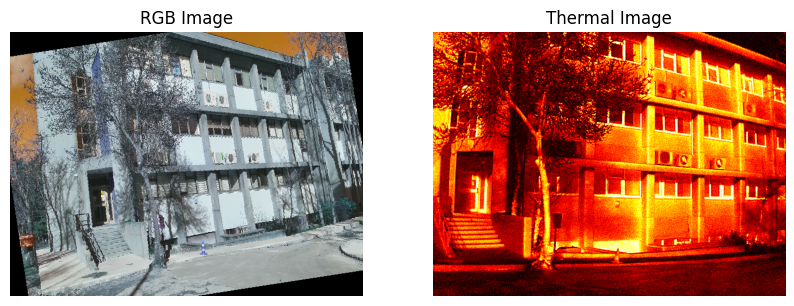

Processing condition: cloudy
Condition: cloudy, Visible Image Shape: torch.Size([8, 480, 640, 3]), Thermal Image Shape: torch.Size([8, 1, 480, 640])


In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def visualize_pair(rgb, thermal):
    """
    Visualize an RGB and thermal image pair.
    """

    # Ensure RGB image is in the correct format for imshow
    if isinstance(rgb, torch.Tensor):
        rgb = rgb.cpu().numpy()  # Convert to NumPy array
    if rgb.dtype != np.uint8:
        rgb = (rgb * 255).astype(np.uint8)  # Convert to uint8 if needed
    if len(rgb.shape) == 3 and rgb.shape[0] in (1, 3):  # If channels are first, move to last
        rgb = rgb.transpose(1, 2, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(thermal.squeeze(0).numpy(), cmap="hot")
    plt.title("Thermal Image")
    plt.axis("off")
    plt.show()

# Define the base directory of the dataset
base_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR"

# List all conditions dynamically (e.g., `cloudy`, `sunny`) and exclude invalid directories
conditions = [
    condition for condition in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, condition)) and condition not in ['index']
]

# Iterate over each condition
dataloaders = {}
for condition in conditions:
    print(f"Processing condition: {condition}")

    # Initialize the dataset for the current condition
    try:
        dataset = ThermalRGBDataset(
            base_dir=base_dir,
            condition=condition,
            img_size=(640, 480),  # Resize to 640x480
            augment=True,         # Enable augmentation
            transform=None        # PyTorch transformations, if needed
        )

        # Create a DataLoader for the current condition
        dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
        dataloaders[condition] = dataloader  # Save DataLoader for later use

        # Optionally: Visualize a sample from each condition
        for visible_img, thermal_img in dataloader:
            print(f"Condition: {condition}, Visible Image Shape: {visible_img.shape}, Thermal Image Shape: {thermal_img.shape}")
            visualize_pair(visible_img[0], thermal_img[0])  # Visualize the first pair
            break

    except FileNotFoundError as e:
        print(f"Skipping condition {condition}: {e}")

### Data Augmentation

We will apply three augmentation techniques:
1. Random Hue, Saturation, and Value (HSV) Adjustment
2. Conversion to Grayscale
3. Cosine Transformation
4. Gaussian Blur

As for the final step, we will create the pipeline to apply the techniques mentioned above.

In [ ]:
# Define paths
input_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR"
output_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Augmentation functions
def adjust_hsv(image):
    """Adjust hue, saturation, and value of the image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue_adjust = np.random.uniform(-10, 10)
    sat_scale = np.random.uniform(0.8, 1.2)
    val_scale = np.random.uniform(0.8, 1.2)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue_adjust, 0, 180)  # Adjust hue
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)   # Scale saturation
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * val_scale, 0, 255)   # Scale value
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def convert_to_grayscale(image):
    """Convert RGB image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def cosine_transform(image):
    """Apply randomized cosine transformation to grayscale image."""
    image = image / 255.0  # Normalize to [0, 1]
    w0, wr, theta_r = 2 * np.pi / 3, np.pi / 2, np.pi / 2
    alpha0, alpha1 = np.random.normal(0, 0.1), np.random.normal(0, 0.1)
    w = w0 + abs(alpha0) * wr
    theta = np.pi / 2 + alpha1 * theta_r
    transformed = np.cos(w * (image - 0.5) + theta)
    transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())  # Normalize
    return (transformed * 255).astype(np.uint8)

def apply_gaussian_blur(image):
    """Apply Gaussian blur to smooth the image."""
    return cv2.GaussianBlur(image, (5, 5), 0)



The complete pipeline

In [ ]:
# Full augmentation pipeline
def augment_and_process(image):
    """
    Full pipeline for augmenting and preprocessing an image.
    Returns a dictionary of processed steps.
    """
    results = {}

    # Original image
    results["original"] = image

    # Step 1: Adjust HSV
    augmented_rgb = adjust_hsv(image)
    results["hsv_adjusted"] = augmented_rgb

    # Step 2: Convert to Grayscale
    grayscale_image = convert_to_grayscale(augmented_rgb)
    results["grayscale"] = grayscale_image

    # Step 3: Apply Cosine Transformation
    pseudo_thermal = cosine_transform(grayscale_image)
    results["cosine_transformed"] = pseudo_thermal

    # Step 4: Apply Gaussian Blur
    smoothed_thermal = apply_gaussian_blur(pseudo_thermal)
    results["gaussian_blurred"] = smoothed_thermal

    return results

### Download the augmented dataset to drive

In [ ]:
# Function to traverse dataset and apply the pipeline
def process_dataset(input_dir, output_dir):
    """
    Traverse the dataset folder structure, process images, and save augmented versions.
    """
    for root, dirs, files in os.walk(input_dir):
        # Recreate the folder structure in the output directory
        relative_path = os.path.relpath(root, input_dir)
        target_folder = os.path.join(output_dir, relative_path)
        os.makedirs(target_folder, exist_ok=True)

        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
                input_file_path = os.path.join(root, file)
                image = cv2.imread(input_file_path)
                if image is None:
                    print(f"Failed to load image: {input_file_path}")
                    continue

                # Convert BGR to RGB for processing
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply augmentation pipeline
                processed_images = augment_and_process(image)

                # Save augmented images
                for key, img in processed_images.items():
                    output_file_name = f"{os.path.splitext(file)[0]}_{key}.jpg"
                    output_file_path = os.path.join(target_folder, output_file_name)

                    if len(img.shape) == 2:  # Grayscale images
                        cv2.imwrite(output_file_path, img)
                    else:  # RGB images
                        cv2.imwrite(output_file_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

                print(f"Processed and saved: {input_file_path}")

!!! do not run this code, the augmented dataset is already uploaded in the drive

In [ ]:
# Run the pipeline
# process_dataset(input_dir, output_dir)

Inspecting augmentations for: IM_02134_hsv


Inspecting augmentations for: IM_02617_hsv


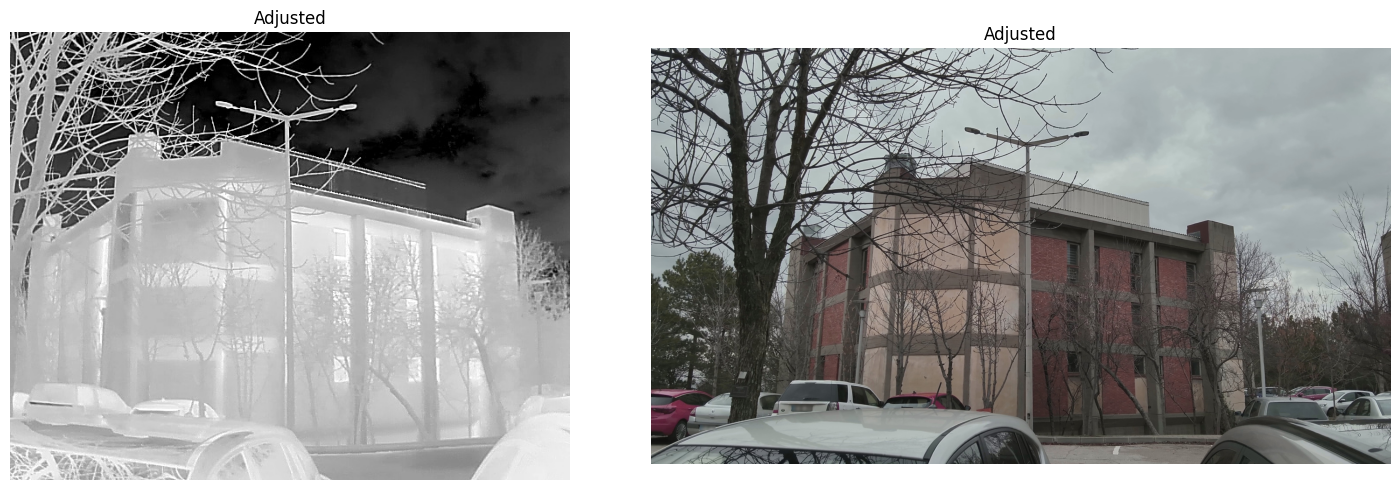

Inspecting augmentations for: IM_06859_hsv


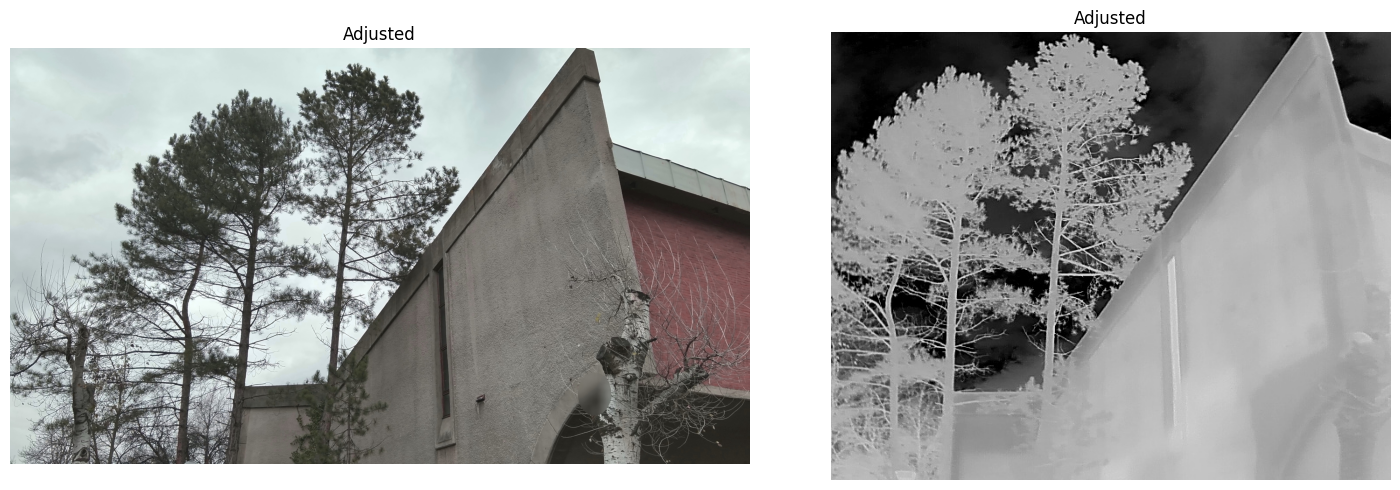

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def inspect_augmentations(augmented_folder, num_samples=5):
    """
    Visually inspect augmented images by displaying a few examples with their augmentations.

    Args:
        augmented_folder (str): Path to the folder containing augmented images.
        num_samples (int): Number of random samples to inspect.
    """
    # Recursively collect all augmented images
    all_files = []
    for root, _, files in os.walk(augmented_folder):
        all_files.extend([os.path.join(root, f) for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])

    if not all_files:
        print(f"No augmented images found in the folder: {augmented_folder}")
        return

    # Group images by their base name
    augmentation_dict = {}
    for file in all_files:
        base_name = "_".join(os.path.basename(file).split("_")[:-1])  # Extract the base name
        if base_name not in augmentation_dict:
            augmentation_dict[base_name] = []
        augmentation_dict[base_name].append(file)

    # Select random samples for inspection
    inspected_samples = list(augmentation_dict.keys())
    if len(inspected_samples) > num_samples:
        inspected_samples = random.sample(inspected_samples, num_samples)

    for base_name in inspected_samples:
        print(f"Inspecting augmentations for: {base_name}")
        augmented_images = augmentation_dict[base_name]

        # Sort by augmentation type for consistent visualization
        augmented_images.sort(key=lambda x: os.path.basename(x).split("_")[-1])

        # Display the original and augmented images
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(augmented_images):
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Get augmentation label
            aug_label = os.path.basename(img_path).split("_")[-1].split(".")[0]

            plt.subplot(1, len(augmented_images), i + 1)
            plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
            plt.title(aug_label.replace("_", " ").capitalize())
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Example usage
augmented_folder = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"
inspect_augmentations(augmented_folder, num_samples=3)

## Training Module

Things to work on

- Backbone
  - ResNET
- Module- pre
  - Coarse matching
  - fine matching
  - fine process (?) (combination of attention and mlp)
  - linear attention
  - transformer
  - xoftr_loss
- XoFTR / LoFTR(https://github.com/zju3dv/LoFTR)

(?) lightning, optimizers, losses


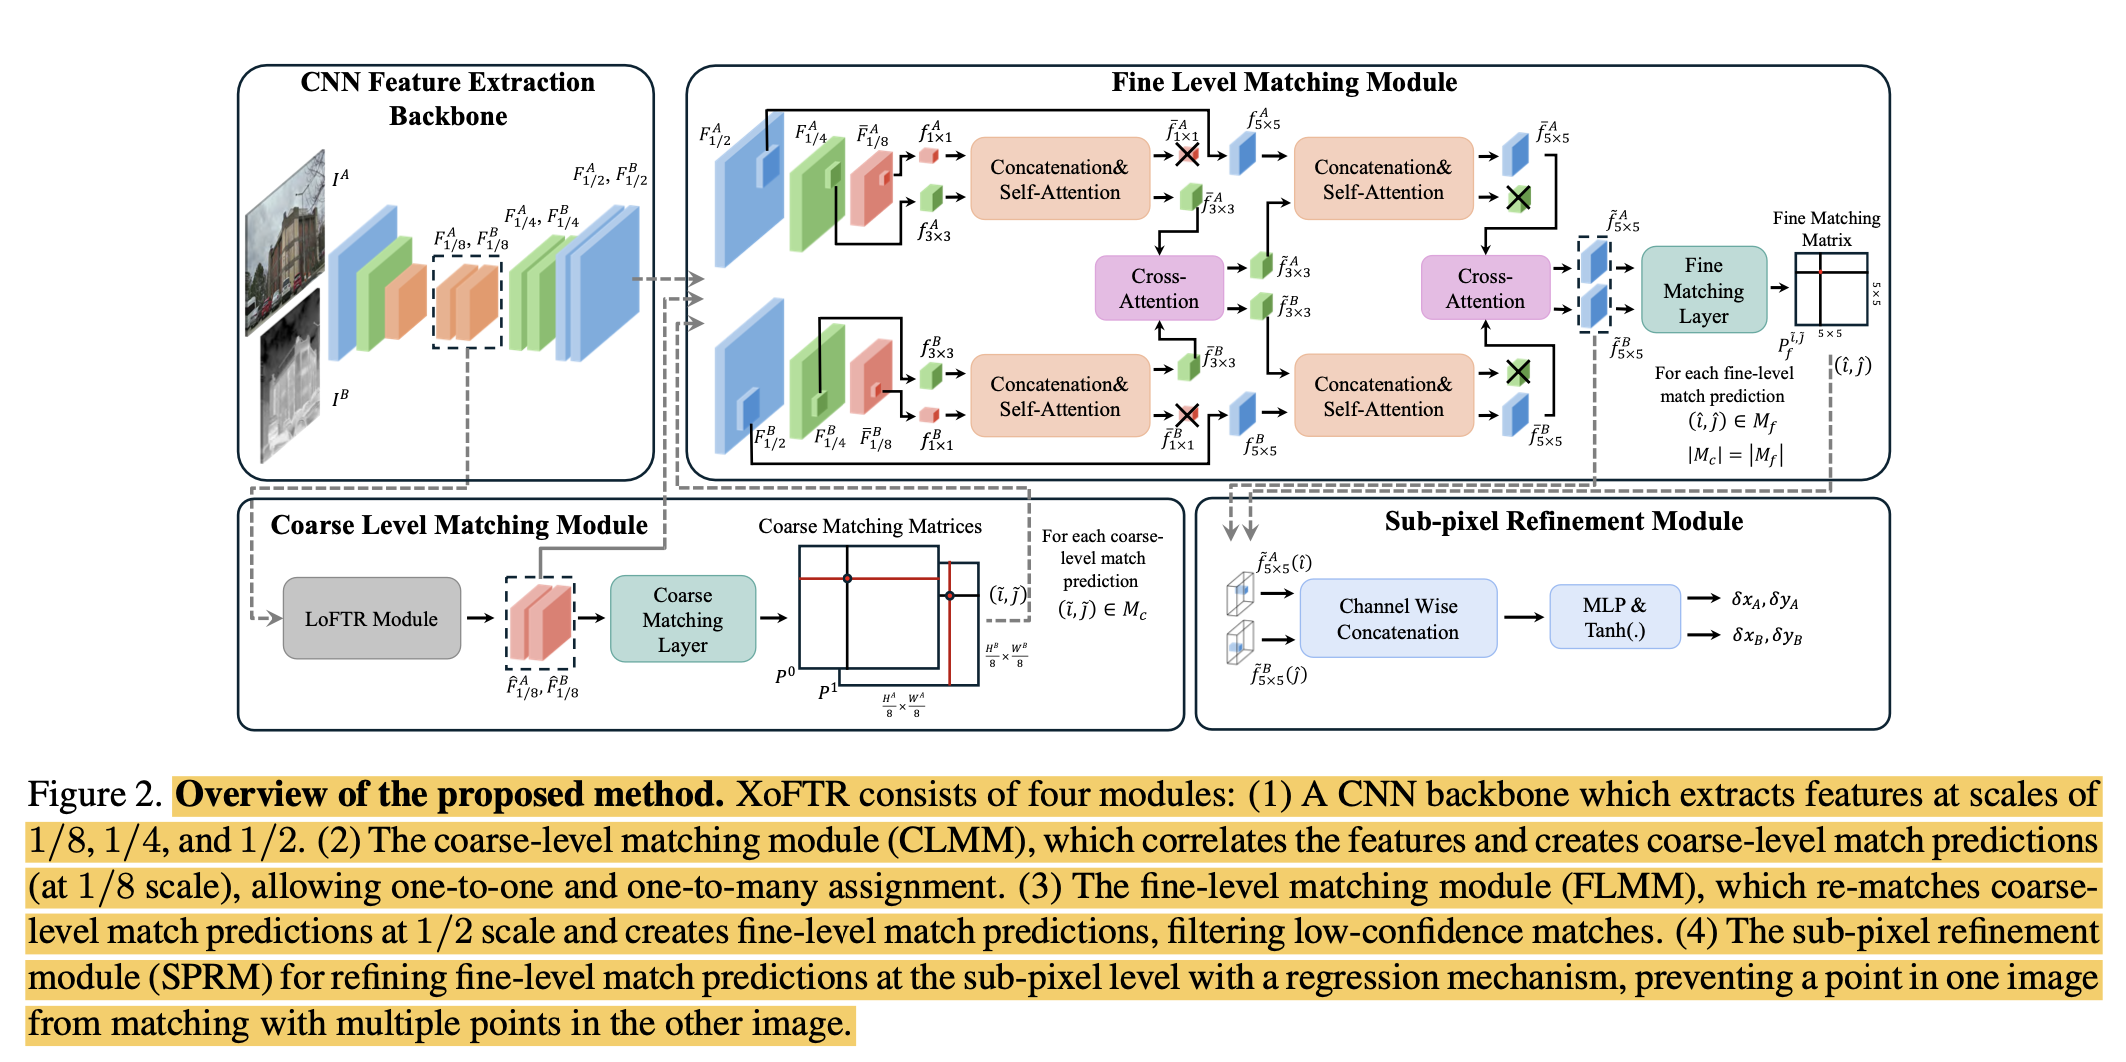

Model Components
- Backbone:
  - A CNN-based backbone (e.g., ResNet) for multi-scale feature extraction.
  - Produces feature maps at scales of 1/8, 1/4, and 1/2.
- Coarse-Level Matching Module:
  - Utilizes one-to-one, one-to-many, and many-to-one matching.
  - Incorporates self- and cross-attention layers for refining feature correspondence.
- Fine-Level Matching Module:
  - Operates at higher resolutions (1/2 scale).
  - Matches coarse-level predictions with additional refinement and confidence filtering.
- Sub-Pixel Refinement Module:
  - Performs regression on match predictions to refine them at sub-pixel accuracy.
- Masked Image Modeling (MIM):
  - Pre-training phase to handle intensity and modality differences.
  - Uses learnable token vectors and reconstructs masked input patches.

In [ ]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.5.0.post0
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: fsspec, lightning-utilities, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [ ]:
!pip install yacs
!pip install pytorch-lightning==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.2/913.2 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.0.post0
    Uninstalling pytorch-lightning-2.5.0.post0:
      Successfully uninstalled pytorch-lightning-2.5.0.post0


In [ ]:
import yacs
import sys
from pathlib import Path

# Base project path
base_path = Path("/content/XoFTR")  # Adjust if your project is in a different location

# Add 'src' path
src_path = base_path / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Add 'configs' path
configs_path = base_path / "configs"
if str(configs_path) not in sys.path:
    sys.path.append(str(configs_path))

# Add any other required paths
data_path = base_path / "data"
if str(data_path) not in sys.path:
    sys.path.append(str(data_path))

print("Paths added successfully!")

Paths added successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

import math
import argparse
import pprint
from distutils.util import strtobool
from pathlib import Path
from loguru import logger as loguru_logger
from datetime import datetime

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.profilers import SimpleProfiler, PassThroughProfiler

from src.config.default import get_cfg_defaults
from src.utils.misc import get_rank_zero_only_logger, setup_gpus
from src.utils.profiler import build_profiler
from src.lightning.data import MultiSceneDataModule
from src.lightning.lightning_xoftr import PL_XoFTR

ImportError: cannot import name 'get_num_classes' from 'torchmetrics.utilities.data' (/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/data.py)

In [ ]:
class TrainerWrapper:
    def __init__(self):
        self.args = None
        self.config = None
        self.profiler = None
        self.model = None
        self.data_module = None
        self.logger = None
        self.trainer = None
        self.callbacks = []

    def parse_args(self):
        parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
        parser.add_argument('data_cfg_path', type=str, help='data config path')
        parser.add_argument('main_cfg_path', type=str, help='main config path')
        parser.add_argument('--exp_name', type=str, default='default_exp_name')
        parser.add_argument('--batch_size', type=int, default=4, help='batch_size per gpu')
        parser.add_argument('--num_workers', type=int, default=4)
        parser.add_argument('--pin_memory', type=lambda x: bool(strtobool(x)), nargs='?', default=True,
                            help='whether loading data to pinned memory or not')
        parser.add_argument('--ckpt_path', type=str, default=None,
                            help='pretrained checkpoint path, helpful for using a pre-trained coarse-only XoFTR')
        parser.add_argument('--disable_ckpt', action='store_true', help='disable checkpoint saving (useful for debugging).')
        parser.add_argument('--profiler_name', type=str, default=None,
                            help='options: [inference, pytorch], or leave it unset')
        parser.add_argument('--parallel_load_data', action='store_true',
                            help='load datasets in with multiple processes.')

        parser = pl.Trainer.add_argparse_args(parser)
        self.args = parser.parse_args()

    def initialize(self):
        rank_zero_only(pprint.pprint)(vars(self.args))

        # Initialize default configuration and merge with the provided config files
        self.config = get_cfg_defaults()
        self.config.merge_from_file(self.args.main_cfg_path)
        self.config.merge_from_file(self.args.data_cfg_path)
        pl.seed_everything(self.config.TRAINER.SEED)  # Reproducibility

        # Scale learning rate and warmup steps automatically
        self.args.gpus = _n_gpus = setup_gpus(self.args.gpus)
        self.config.TRAINER.WORLD_SIZE = _n_gpus * self.args.num_nodes
        self.config.TRAINER.TRUE_BATCH_SIZE = self.config.TRAINER.WORLD_SIZE * self.args.batch_size
        _scaling = self.config.TRAINER.TRUE_BATCH_SIZE / self.config.TRAINER.CANONICAL_BS
        self.config.TRAINER.SCALING = _scaling
        self.config.TRAINER.TRUE_LR = self.config.TRAINER.CANONICAL_LR * _scaling
        self.config.TRAINER.WARMUP_STEP = math.floor(self.config.TRAINER.WARMUP_STEP / _scaling)

        # Initialize profiler, model, and data module
        self.profiler = build_profiler(self.args.profiler_name)
        self.model = PL_XoFTR(self.config, pretrained_ckpt=self.args.ckpt_path, profiler=self.profiler)
        loguru_logger.info("XoFTR LightningModule initialized!")

        self.data_module = MultiSceneDataModule(self.args, self.config)
        loguru_logger.info("XoFTR DataModule initialized!")

        # Initialize loggers
        self.logger = [TensorBoardLogger(save_dir='logs/tb_logs', name=self.args.exp_name, default_hp_metric=False)]
        if self.config.TRAINER.USE_WANDB:
            self.logger.append(WandbLogger(
                name=self.args.exp_name + f"_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}",
                project='XoFTR'))

        # Initialize callbacks
        ckpt_dir = Path(self.logger[0].log_dir) / 'checkpoints'
        ckpt_callback = ModelCheckpoint(monitor='auc@10', verbose=True, save_top_k=-1, mode='max',
                                        save_last=True, dirpath=str(ckpt_dir),
                                        filename='{epoch}-{auc@5:.3f}-{auc@10:.3f}-{auc@20:.3f}')
        lr_monitor = LearningRateMonitor(logging_interval='step')
        self.callbacks = [lr_monitor]
        if not self.args.disable_ckpt:
            self.callbacks.append(ckpt_callback)

        # Initialize Trainer
        self.trainer = pl.Trainer.from_argparse_args(
            self.args,
            plugins=DDPPlugin(
                find_unused_parameters=True,
                num_nodes=self.args.num_nodes,
                sync_batchnorm=self.config.TRAINER.WORLD_SIZE > 0),
            gradient_clip_val=self.config.TRAINER.GRADIENT_CLIPPING,
            callbacks=self.callbacks,
            logger=self.logger,
            sync_batchnorm=self.config.TRAINER.WORLD_SIZE > 0,
            replace_sampler_ddp=False,  # use custom sampler
            reload_dataloaders_every_epoch=False,  # avoid repeated samples!
            weights_summary='full',
            profiler=self.profiler)
        loguru_logger.info("Trainer initialized!")

    def train(self):
        loguru_logger.info("Start training!")
        self.trainer.fit(self.model, datamodule=self.data_module)

if __name__ == '__main__':
    trainer_wrapper = TrainerWrapper()
    trainer_wrapper.parse_args()
    trainer_wrapper.initialize()


NameError: name 'pl' is not defined

In [ ]:
class XoFTR(nn.Module):
    def __init__(self):
        super(XoFTR, self).__init__()

        # Backbone (ResNet-based feature extractor)
        self.backbone = resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove fully connected layers

        # Coarse-Level Matching Module
        self.coarse_self_attention = nn.MultiheadAttention(embed_dim=256, num_heads=8)
        self.coarse_cross_attention = nn.MultiheadAttention(embed_dim=256, num_heads=8)

        # Fine-Level Matching Module
        self.fine_decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
        )

        # Sub-Pixel Refinement Module
        self.sub_pixel_regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # Outputs (delta_xA, delta_yA, delta_xB, delta_yB)
            nn.Tanh()
        )

    def forward(self, visible, thermal):
        # Feature extraction
        visible_features = self.backbone(visible)  # Shape: [B, C, H/8, W/8]
        thermal_features = self.backbone(thermal)  # Shape: [B, C, H/8, W/8]

        # Flatten spatial dimensions for attention layers
        visible_flat = visible_features.flatten(2).permute(2, 0, 1)  # [HW, B, C]
        thermal_flat = thermal_features.flatten(2).permute(2, 0, 1)  # [HW, B, C]

        # Coarse-Level Matching
        coarse_visible = self.coarse_self_attention(visible_flat, visible_flat, visible_flat)[0]
        coarse_thermal = self.coarse_cross_attention(thermal_flat, visible_flat, visible_flat)[0]

        # Reshape back to spatial dimensions
        coarse_visible = coarse_visible.permute(1, 2, 0).view_as(visible_features)
        coarse_thermal = coarse_thermal.permute(1, 2, 0).view_as(thermal_features)

        # Fine-Level Matching
        fine_visible = self.fine_decoder(coarse_visible)
        fine_thermal = self.fine_decoder(coarse_thermal)

        # Sub-Pixel Refinement
        fine_flat = torch.cat([fine_visible.flatten(2), fine_thermal.flatten(2)], dim=1)  # Concatenate features
        sub_pixel_offsets = self.sub_pixel_regressor(fine_flat.permute(2, 0, 1))  # [B, 4]

        return sub_pixel_offsets

# Loss functions

def coarse_matching_loss(predicted, ground_truth):
    """
    Computes the coarse-level matching loss using Focal Loss.
    Args:
        predicted: Predicted matching probabilities (B, HW, HW).
        ground_truth: Ground truth matching matrix (B, HW, HW).
    Returns:
        Loss value.
    """
    focal_loss = -ground_truth * torch.pow(1 - predicted, 2) * torch.log(predicted + 1e-8)
    return focal_loss.mean()

def fine_matching_loss(predicted, ground_truth):
    """
    Computes the fine-level matching loss using Focal Loss.
    Args:
        predicted: Predicted fine-level matching probabilities (B, N, N).
        ground_truth: Ground truth fine-level matching matrix (B, N, N).
    Returns:
        Loss value.
    """
    focal_loss = -ground_truth * torch.pow(1 - predicted, 2) * torch.log(predicted + 1e-8)
    return focal_loss.mean()

def sub_pixel_refinement_loss(estimated_matches, essential_matrix):
    """
    Computes the sub-pixel refinement loss using symmetric epipolar distance.
    Args:
        estimated_matches: Predicted matching coordinates (B, N, 4), where 4 = (xA, yA, xB, yB).
        essential_matrix: Ground truth essential matrix (B, 3, 3).
    Returns:
        Loss value.
    """
    xA = estimated_matches[..., :2]  # (xA, yA)
    xB = estimated_matches[..., 2:]  # (xB, yB)

    # Homogeneous coordinates
    xA_h = torch.cat([xA, torch.ones_like(xA[..., :1])], dim=-1)  # (xA, yA, 1)
    xB_h = torch.cat([xB, torch.ones_like(xB[..., :1])], dim=-1)  # (xB, yB, 1)

    # Symmetric epipolar distance
    ExB = torch.matmul(essential_matrix, xB_h.transpose(-1, -2))  # (B, 3, N)
    xAExB = torch.sum(xA_h * ExB.transpose(-1, -2), dim=-1)  # (B, N)
    dist = torch.pow(xAExB, 2) / (
        torch.norm(ExB[..., :2, :], dim=1) + torch.norm(torch.matmul(essential_matrix.transpose(-1, -2), xA_h), dim=1)
    )

    return dist.mean()

# Overall loss

def total_loss(coarse_pred, coarse_gt, fine_pred, fine_gt, sub_pixel_matches, essential_matrix):
    """
    Combines all loss components into a single loss value.
    Args:
        coarse_pred: Predicted coarse-level matching probabilities.
        coarse_gt: Ground truth coarse-level matching matrix.
        fine_pred: Predicted fine-level matching probabilities.
        fine_gt: Ground truth fine-level matching matrix.
        sub_pixel_matches: Predicted sub-pixel matches.
        essential_matrix: Ground truth essential matrix.
    Returns:
        Total loss value.
    """
    lambda_c = 0.5
    lambda_f = 0.3
    lambda_s = 1.0

    lc = coarse_matching_loss(coarse_pred, coarse_gt)
    lf = fine_matching_loss(fine_pred, fine_gt)
    ls = sub_pixel_refinement_loss(sub_pixel_matches, essential_matrix)

    return lambda_c * lc + lambda_f * lf + lambda_s * ls

# Example Usage
if __name__ == "__main__":
    model = XoFTR()
    visible = torch.rand(1, 3, 256, 256)  # Example visible image
    thermal = torch.rand(1, 3, 256, 256)  # Example thermal image

    output = model(visible, thermal)
    print("Sub-Pixel Offsets:", output)


## LoFTR testing

In [ ]:
#Initing the model
loftr = LoFTR(pretrained="outdoor")  # Use "indoor" for indoor datasets
loftr.eval()  # Set the model to evaluation mode


Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt
100%|██████████| 44.2M/44.2M [00:02<00:00, 16.2MB/s]


LoFTR(
  (backbone): ResNetFPN_8_2(
    (conv1): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [ ]:
from torchvision.transforms import ToTensor

Prepare input data

In [ ]:
# Load your RGB and Thermal images (ensure these are aligned and grayscale)
rgb_image_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/thermal/images/IM_00036.jpg"  # Replace with your RGB image path
thermal_image_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/visible/images/IM_00036.jpg"  # Replace with your thermal image path

# Read the images in grayscale
rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_GRAYSCALE)
thermal_image = cv2.imread(thermal_image_path, cv2.IMREAD_GRAYSCALE)

# Resize the images to a fixed size (LoFTR expects a standard size like 480x640)
rgb_resized = cv2.resize(rgb_image, (640, 480))
thermal_resized = cv2.resize(thermal_image, (640, 480))

# Convert images to tensors and normalize
transform = ToTensor()
rgb_tensor = transform(rgb_resized).unsqueeze(0)  # Add batch dimension
thermal_tensor = transform(thermal_resized).unsqueeze(0)

# Prepare input dictionary for LoFTR
input_data = {
    "image0": rgb_tensor,
    "image1": thermal_tensor,
}

NameError: name 'ToTensor' is not defined

Run LoFTR

In [ ]:
# Run LoFTR on the input images
with torch.no_grad():
    output = loftr(input_data)

# Extract matches
keypoints0 = output["keypoints0"].cpu().numpy()  # Keypoints in RGB image
keypoints1 = output["keypoints1"].cpu().numpy()  # Keypoints in Thermal image
confidence = output["confidence"].cpu().numpy()  # Confidence scores

NameError: name 'loftr' is not defined

Visualize

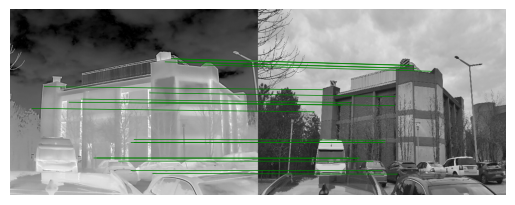

In [ ]:
# Function to visualize matches
def draw_matches(img1, img2, kpts1, kpts2):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.imshow(canvas, cmap="gray")
    i=0
    for (x1, y1), (x2, y2) in zip(kpts1, kpts2):
        if (confidence[i]>0.8):
          plt.plot([x1, x2 + w1], [y1, y2], color="g", linewidth=0.5)
        i+=1
    plt.axis("off")
    plt.show()

# Call the visualization function
draw_matches(rgb_resized, thermal_resized, keypoints0, keypoints1)

In [ ]:
#One More Example, Just one more is enough

# Load your RGB and Thermal images (ensure these are aligned and grayscale)
rgb_image_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_2/visible/images/IM_04490.jpg"  # Replace with your RGB image path
thermal_image_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_2/thermal/images/IM_04490.jpg"  # Replace with your thermal image path

# Read the images in grayscale
rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_GRAYSCALE)
thermal_image = cv2.imread(thermal_image_path, cv2.IMREAD_GRAYSCALE)

# Resize the images to a fixed size (LoFTR expects a standard size like 480x640)
rgb_resized = cv2.resize(rgb_image, (640, 480))
thermal_resized = cv2.resize(thermal_image, (640, 480))

# Convert images to tensors and normalize
transform = ToTensor()
rgb_tensor = transform(rgb_resized).unsqueeze(0)  # Add batch dimension
thermal_tensor = transform(thermal_resized).unsqueeze(0)

# Prepare input dictionary for LoFTR
input_data = {
    "image0": rgb_tensor,
    "image1": thermal_tensor,
}

# Run LoFTR on the input images
with torch.no_grad():
    output = loftr(input_data)

# Extract matches
keypoints0 = output["keypoints0"].cpu().numpy()  # Keypoints in RGB image
keypoints1 = output["keypoints1"].cpu().numpy()  # Keypoints in Thermal image
confidence = output["confidence"].cpu().numpy()  # Confidence scores



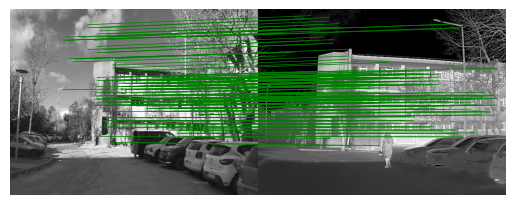

In [ ]:
# Call the visualization function
draw_matches(rgb_resized, thermal_resized, keypoints0, keypoints1)

In [ ]:
#fireman

# Load your RGB and Thermal images (ensure these are aligned and grayscale)
rgb_image_path = "/content/frame_test_mm_fire_0001.jpg"  # Replace with your RGB image path
thermal_image_path = "/content/frame_test_mm_fire_0001_T.jpg"  # Replace with your thermal image path

# Read the images in grayscale
rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_GRAYSCALE)
thermal_image = cv2.imread(thermal_image_path, cv2.IMREAD_GRAYSCALE)

# Resize the images to a fixed size (LoFTR expects a standard size like 480x640)
rgb_resized = cv2.resize(rgb_image, (640, 480))
thermal_resized = cv2.resize(thermal_image, (640, 480))

# Convert images to tensors and normalize
transform = ToTensor()
rgb_tensor = transform(rgb_resized).unsqueeze(0)  # Add batch dimension
thermal_tensor = transform(thermal_resized).unsqueeze(0)

# Prepare input dictionary for LoFTR
input_data = {
    "image0": rgb_tensor,
    "image1": thermal_tensor,
}

# Run LoFTR on the input images
with torch.no_grad():
    output = loftr(input_data)

# Extract matches
keypoints0 = output["keypoints0"].cpu().numpy()  # Keypoints in RGB image
keypoints1 = output["keypoints1"].cpu().numpy()  # Keypoints in Thermal image
confidence = output["confidence"].cpu().numpy()  # Confidence scores

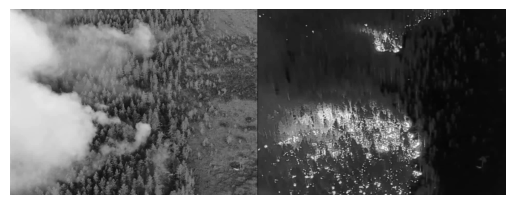

In [ ]:
# Call the visualization function
draw_matches(rgb_resized, thermal_resized, keypoints0, keypoints1)

## XoFTR testing


Clone

In [ ]:
#Clone
!git clone https://github.com/OnderT/XoFTR.git
%cd XoFTR

Cloning into 'XoFTR'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 483 (delta 0), reused 3 (delta 0), pack-reused 479 (from 1)
Receiving objects: 100% (483/483), 181.76 MiB | 25.66 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (372/372), done.
/content/XoFTR


Installing Dependencies

In [ ]:
#DO NOT RUN 01/15/2024, somehow fails and we don't need it
#Installing Dependencies
!pip install -r requirements.txt

Downloading Pretrained Weight

In [ ]:
#Downloading Pretrained Weight
%cd /content/XoFTR
!mkdir weights
%cd weights
!gdown --id 1oRkEGsLpPIxlulc6a7c2q5H1XTNbfkVj
%cd /content/XoFTR

/content/XoFTR
/content/XoFTR/weights
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oRkEGsLpPIxlulc6a7c2q5H1XTNbfkVj
From (redirected): https://drive.google.com/uc?id=1oRkEGsLpPIxlulc6a7c2q5H1XTNbfkVj&confirm=t&uuid=5c795cfe-9a14-4322-a878-9970a88dcb1a
To: /content/XoFTR/weights/weights_xoftr_640.ckpt
100% 44.5M/44.5M [00:00<00:00, 66.4MB/s]
/content/XoFTR


Import XoFTR and load Pretrained Weights

In [ ]:
!pip install yacs
!pip install loguru
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 33.9 MB/s eta 0:00:00


Test XoFTR

In [ ]:
# Run once
%cd /content/XoFTR
import os
import torch
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure
%matplotlib inline

/content/XoFTR


In [ ]:
%cd /content/XoFTR

/content/XoFTR


In [ ]:
import torch
import io
import cv2
import numpy as np

from src.xoftr import XoFTR
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config
from src.utils.data_io import DataIOWrapper

In [ ]:
def perform_inference(thermal_path, visible_path, weights_path="/content/XoFTR/weights/weights_xoftr_640.ckpt", coarse_thr=0.3, fine_thr=0.1, denser=False):
    # Load configuration
    config = get_cfg_defaults(inference=True)
    config = lower_config(config)

    # Set thresholds
    config['xoftr']['match_coarse']['thr'] = coarse_thr
    config['xoftr']['fine']['thr'] = fine_thr
    config['xoftr']['fine']['denser'] = denser

    # Load the model
    matcher = XoFTR(config=config["xoftr"])
    device = torch.device('cpu')
    ckpt = torch.load(weights_path, map_location='cpu', weights_only=True)
    matcher.load_state_dict(ckpt['state_dict'], strict=True)
    matcher = matcher.eval()

    # Read images
    img0_raw = cv2.imread(visible_path)
    img1_raw = cv2.imread(thermal_path)

    # Resize images to dimensions divisible by 8
    img0_size = (640, 360)
    img1_size = (640, 512)
    img0_raw = cv2.resize(img0_raw, (img0_size[0] // 8 * 8, img0_size[1] // 8 * 8))
    img1_raw = cv2.resize(img1_raw, (img1_size[0] // 8 * 8, img1_size[1] // 8 * 8))

    # Convert to grayscale and normalize

    img0 = torch.from_numpy(cv2.cvtColor(img0_raw, cv2.COLOR_BGR2GRAY))[None][None] / 255.
    img1 = torch.from_numpy(cv2.cvtColor(img1_raw, cv2.COLOR_BGR2GRAY))[None][None] / 255.

    # Create batch
    batch = {'image0': img0, 'image1': img1}

    # Inference
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf_f'].cpu().numpy()

    return img0_raw, img1_raw, mkpts0, mkpts1, mconf

In [ ]:
def visualize_matches(img0, img1, mkpts0, mkpts1, mconf, save_path=None):
    color = cm.jet(mconf)
    text = [
        'XoFTR',
        'Matches: {}'.format(len(mconf)),
    ]

    # Convert images to RGB
    if len(img0.shape) == 3:
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    # Plot matches
    fig = make_matching_figure(img0, img1, mkpts0, mkpts1, color, text=text, dpi=125)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
img0_raw, img1_raw, mkpts0, mkpts1, mconf = perform_inference("/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/thermal/images/IM_00036.jpg", "/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/visible/images/IM_00036.jpg")

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


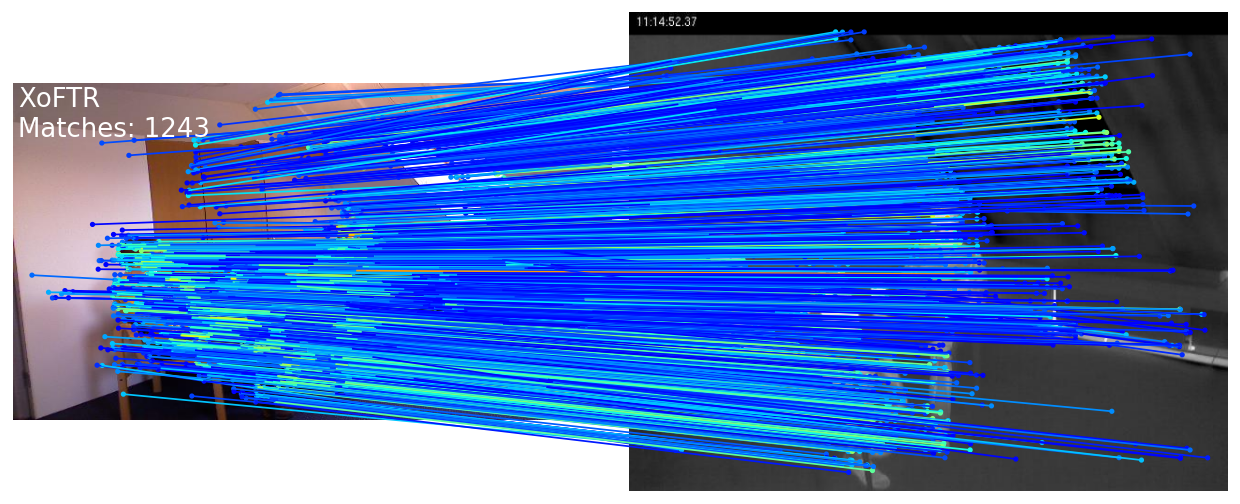

In [ ]:
visualize_matches(img0_raw, img1_raw, mkpts0, mkpts1, mconf, save_path="matches.png")

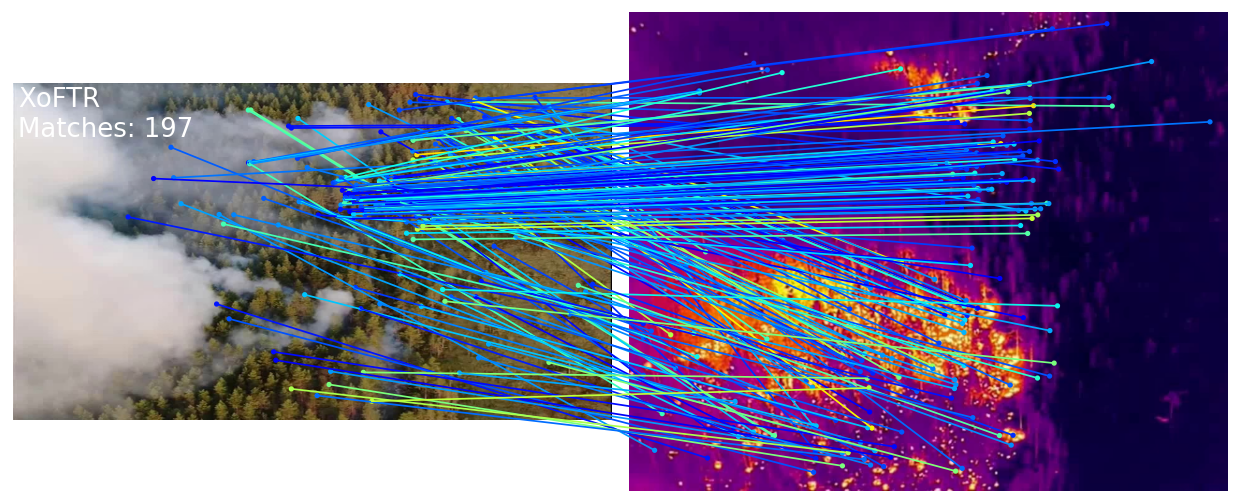

In [ ]:
img0_raw, img1_raw, mkpts0, mkpts1, mconf = perform_inference("/content/1T.jpeg", "/content/1R.jpeg")
visualize_matches(img0_raw, img1_raw, mkpts0, mkpts1, mconf, save_path="matches.png")

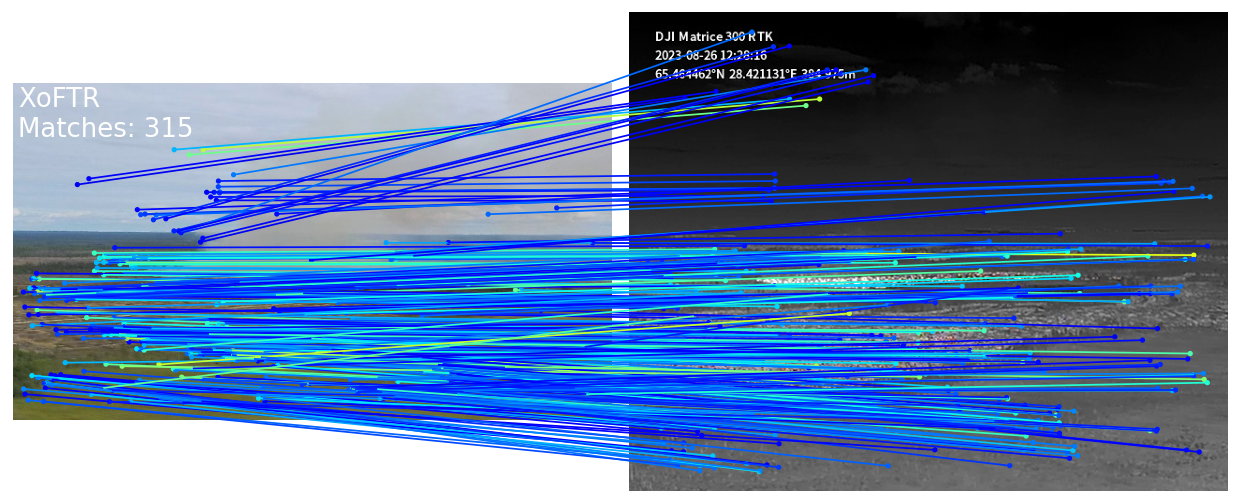

In [ ]:
img0_raw, img1_raw, mkpts0, mkpts1, mconf = perform_inference("/content/2T.jpeg", "/content/2R.jpeg")
visualize_matches(img0_raw, img1_raw, mkpts0, mkpts1, mconf, save_path="matches.png")

Fine-Tune / Extend

In [ ]:
config.DATASET.DATA_ROOT = "path_to_your_dataset"
config.SOLVER.MAX_EPOCHS = 50
config.SOLVER.LR = 1e-4

In [ ]:
python train.py --config-file path/to/config.yaml

# Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(epochs):
    for batch in dataloader:
        visible, thermal, labels = batch
        output = model(visible, thermal)
        loss = compute_loss(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the hierarchy of the system
hierarchy = {
    "System": [
        "Model",
        "Drone",
        "Data Layer",
        "Server",
        "User Interface"
    ],
    "Model": [
        "Feature Extraction Module",
        "CLMM",
        "FLMM",
        "SPRM"
    ],
    "Drone": [
        "Image Acquisition",
        "Data Transmission"
    ],
    "Data Layer": [
        "Raw Image Storage",
        "Processed Data Storage",
        "Augmented Data Management"
    ],
    "Server": [
        "API Management",
        "Data Processing",
        "Model Hosting"
    ],
    "User Interface": [
        "Data Upload",
        "Progress Monitoring",
        "Result Visualization"
    ]
}

# Create a directed graph
G = nx.DiGraph()

# Add edges based on the hierarchy
for parent, children in hierarchy.items():
    for child in children:
        G.add_edge(parent, child)

# Define a layout for the graph
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=True, arrows=False,
    node_size=3000, node_color="#add8e6", font_size=10, font_color="black"
)

# Show the plot
plt.title("Subsystem Decomposition Diagram", fontsize=14)
plt.show()


ImportError: requires pygraphviz http://pygraphviz.github.io/

# Our Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import torch.quantization as quant

## Backbone

In [7]:
#ConvNext

import torch
import timm
from torch import nn

# Load a pre-trained ConvNeXt model
convnext = timm.create_model('convnext_base', pretrained=True)

# Examine the model structure
print(convnext)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [8]:

# Load a pre-trained DeiT model
deit_model = timm.create_model('deit_base_patch16_224', pretrained=True)

# Examine the model structure
print(deit_model)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [9]:
#Swin Transformer
# Load a pre-trained Swin Transformer model
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Examine the model structure
print(swin_model)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [10]:
backbone = deit_model  # or swin_model, or any other appropriate model

In [11]:
#fine Tuning Deit and Swin
# Freeze early layers for fine-tuning
for param in list(backbone.parameters())[:100]:  # Adjust as needed
    param.requires_grad = False


In [12]:
ConvNext_backbone = nn.Sequential(*list(convnext.children())[:-2]) # Remove the classification head (head) for backbone usage

DeIT_backbone = nn.Sequential(*list(deit_model.children())[:-1])  # Remove the classification head

Swin_backbone = nn.Sequential(*list(swin_model.children())[:-1])  # Remove the last classification layer

import timm
import timm
import torch.nn as nn

class HybridBackbone(nn.Module):
    def __init__(self, backbone_name, features_only=False):
        super(HybridBackbone, self).__init__()

        # Create the model based on the backbone_name
        self.backbone = timm.create_model(backbone_name, pretrained=True, features_only=features_only)

        # Determine the output channels based on the model type
        if features_only:
            if hasattr(self.backbone, 'feature_info'):
                print("feature_info found")
                self.out_channels = [f["num_chs"] for f in self.backbone.feature_info]  # Extract channels correctly
            elif hasattr(self.backbone, 'num_features'):
                print(f"feature_info NOT found, using num_features ({self.backbone.num_features})")
                self.out_channels = [self.backbone.num_features]  # Use num_features as fallback
            else:
                raise ValueError(f"Backbone {backbone_name} does not support 'feature_info' or 'num_features'.")
        else:
            self.out_channels = [self.backbone.num_features] if hasattr(self.backbone, 'num_features') else None

    def forward(self, x):
        # Return the final output for the model
        return self.backbone(x)


KeyPoint Backbone

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KeypointBackbone(nn.Module):
    def __init__(self, backbone_name="swin_base_patch4_window7_224"):
        super(KeypointBackbone, self).__init__()

        # Use the same backbone (e.g., ConvNeXt, Swin Transformer, etc.)
        self.backbone = create_model(backbone_name, pretrained=True, features_only=True)
        self.out_channels = self.backbone.feature_info.channels()  # Feature map channels

        # Add layers for keypoint detection
        self.keypoint_head = nn.Sequential(
            nn.Conv2d(self.out_channels[-1], 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=3, padding=1),  # Single channel for heatmap
            nn.Sigmoid()  # Heatmap values between 0 and 1
        )

        # Add layers for descriptor extraction (optional, depending on the use case)
        self.descriptor_head = nn.Sequential(
            nn.Conv2d(self.out_channels[-1], 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # Descriptor length of 128
        )

    def forward(self, image):
        # Extract features from the backbone
        features = self.backbone(image)

        # Generate keypoint heatmap (low-resolution)
        keypoint_heatmap = self.keypoint_head(features[-1])

        # Generate descriptors (based on feature map at the same resolution)
        descriptors = self.descriptor_head(features[-1])

        # Apply non-maximum suppression to keypoint heatmap
        keypoints = self.nms(keypoint_heatmap)

        return keypoints, descriptors

    def nms(self, heatmap, threshold=0.5):
        """
        Perform non-maximum suppression on the keypoint heatmap.
        Only the local maxima are retained.
        """
        # Apply threshold to remove low confidence points
        keypoints = (heatmap > threshold).float()

        # Apply a local max suppression strategy (could be implemented as a 3x3 max filter)
        # For simplicity, just return the thresholded points for now.
        return keypoints


## Feature Matching with SuperGlue (Requires Cloning GIT REPO)

In [14]:
%cd /content
!rm -rf /content/SuperGluePretrainedNetwork
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork
%cd /content/SuperGluePretrainedNetwork


/content
Cloning into 'SuperGluePretrainedNetwork'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 185 (delta 0), reused 0 (delta 0), pack-reused 184 (from 2)
Receiving objects: 100% (185/185), 118.85 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/SuperGluePretrainedNetwork


In [15]:
import sys
import os
print(os.getcwd())  # Print the current working directory



/content/SuperGluePretrainedNetwork


In [16]:
import torch
sys.path.insert(0, "/content/SuperGluePretrainedNetwork")
from models.superglue import SuperGlue

# Define your custom configuration (optional)
config = {
    'descriptor_dim': 256,  # Dimension of the feature descriptor
    'weights': 'outdoor',  # or 'outdoor'
    'keypoint_encoder': [32, 64, 128, 256],
    'GNN_layers': ['self', 'cross'] * 9,
    'sinkhorn_iterations': 100,
    'match_threshold': 0.2,
}

#from models.superglue import SuperGlue
#from models.utils import read_image, draw_matches

# Load the pre-trained SuperGlue model
model = SuperGlue(config)


Loaded SuperGlue model ("outdoor" weights)


In [17]:
import cv2
import numpy as np

def detect_keypoints(image):
    # Check if the image is loaded properly
    if image is None:
        raise ValueError("Image not loaded correctly. Please check the file path.")

    # Use any keypoint detection method like SuperPoint or SIFT
    # For simplicity, let's use ORB (you can replace this with SuperPoint or another method)
    orb = cv2.ORB_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)
    return kp, des

#basic test for function
# Load the images
image1 = cv2.imread('/content/drive/MyDrive/Augmented_Data/test/test-org-img/10163.jpg')
image2 = cv2.imread('/content/drive/MyDrive/Augmented_Data/test/test-org-img/10164.jpg')

# Check if images are loaded correctly
if image1 is None:
    print("Error loading image1.jpg")
if image2 is None:
    print("Error loading image2.jpg")

# Detect keypoints if images are loaded
if image1 is not None and image2 is not None:
    kp1, des1 = detect_keypoints(image1)
    kp2, des2 = detect_keypoints(image2)



In [18]:
#from models.superglue import SuperGlue

class SuperGlueMatcher(nn.Module):
    def __init__(self):
        super(SuperGlueMatcher, self).__init__()
        self.superglue = SuperGlue({"weights": "outdoor"})

    def forward(self, descriptors0, descriptors1, keypoints0, keypoints1):
        # Pass features through SuperGlue
        data = {
            "descriptors0": descriptors0,
            "descriptors1": descriptors1,
            "keypoints0": keypoints0,
            "keypoints1": keypoints1,
        }
        return self.superglue(data)


Modify Forward Pass to Integrate SuperGlue
You'll need to:

Convert your backbone features into keypoints and descriptors (if using SuperPoint).
Pass these keypoints and descriptors to SuperGlue.
Handle the output of SuperGlue (matched keypoints).
Pass the matches to your fine-level matching decoder and optical flow for refinement.

## Self-Supervised Learning

In [19]:
class ContrastiveLearningPretrain(nn.Module):
    def __init__(self, backbone):
        super(ContrastiveLearningPretrain, self).__init__()
        self.backbone = backbone
        self.projection_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

    def forward(self, x):
        features = self.backbone(x)
        projected = self.projection_head(features[-1])  # Use the last feature map
        return projected

def info_nce_loss(features0, features1, temperature=0.1):
    batch_size = features0.size(0)
    labels = torch.arange(batch_size).cuda()
    similarity_matrix = torch.matmul(features0, features1.T) / temperature
    return nn.CrossEntropyLoss()(similarity_matrix, labels)


## Loss Function

In [20]:
#Soft contrastive Loss
def soft_contrastive_loss(predicted, ground_truth, confidence):
    pos_loss = -confidence * torch.log(predicted + 1e-8) * ground_truth
    neg_loss = -(1 - confidence) * torch.log(1 - predicted + 1e-8) * (1 - ground_truth)
    return (pos_loss + neg_loss).mean()

#Geometric Consistency Loss
def geometric_consistency_loss(keypoints0, keypoints1, homography_matrix):
    predicted_keypoints1 = torch.matmul(homography_matrix, keypoints0.T).T
    error = torch.norm(predicted_keypoints1 - keypoints1, dim=1)
    return error.mean()



## Sub-pixel Refinement Module (NEED GIT CLONING REPO)

RAFT

In [21]:
%cd /content
!rm -rf RAFT  # Remove the existing directory
!git clone https://github.com/princeton-vl/RAFT.git
%cd RAFT

/content
Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 147 (delta 0), reused 0 (delta 0), pack-reused 146 (from 2)
Receiving objects: 100% (147/147), 10.01 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/RAFT


In [ ]:
!pip install torchvision tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [22]:
!chmod +x download_models.sh
!./download_models.sh



--2025-02-03 14:14:06--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.85.15, 2620:100:6035:15::a27d:550f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.85.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  25.9MB/s    in 3.2s    

2025-02-03 14:14:10 (24.6 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   


In [23]:
import sys
sys.path.append("/content/RAFT")

In [ ]:
!ls /content/RAFT/core/raft.py


/content/RAFT/core/raft.py


In [25]:
import argparse
#normal args
# Create a dummy args object
args = argparse.Namespace()
args.small = False                # or True, depending on which version you want
args.corr_levels = 4
args.corr_radius = 4
args.dropout = 0
args.alternate_corr = False
args.mixed_precision = False

In [26]:
import torch
import torch.nn as nn
sys.path.append("/content/RAFT/core")
from raft import RAFT
import argparse

class SubPixelRefinementWithFlow(nn.Module):
    def __init__(self):
        super(SubPixelRefinementWithFlow, self).__init__()
        self.optical_flow = RAFT(args)

    def forward(self, image0, image1, initial_matches):
        """
        Refines the initial matches using optical flow.

        Args:
            image0 (torch.Tensor): The first image (batch_size, channels, height, width)
            image1 (torch.Tensor): The second image (batch_size, channels, height, width)
            initial_matches (dict): The initial matches from the feature matching module.

        Returns:
            refined_matches (dict): The refined matches after optical flow refinement.
        """
        # The `initial_matches` dictionary typically contains the keypoints and their initial matching confidence.
        # We will assume it contains 'keypoints0' and 'keypoints1', which are the coordinates of matched points.

        keypoints0 = initial_matches['keypoints0']  # Extract initial keypoints from the match data
        keypoints1 = initial_matches['keypoints1']

        # Use RAFT optical flow to predict flow between the images
        flow = self.optical_flow(image0, image1)

        # Apply the flow to refine the keypoints in both images
        refined_keypoints0 = keypoints0 + flow.sample(keypoints0)  # Refining the keypoints based on the flow
        refined_keypoints1 = keypoints1 + flow.sample(keypoints1)  # Refining the keypoints based on the flow

        refined_matches = {
            'refined_keypoints0': refined_keypoints0,
            'refined_keypoints1': refined_keypoints1,
            'confidence': initial_matches['confidence'],  # You can keep the confidence from initial matches
        }

        return refined_matches

## Scale-Aware Matching

In [27]:
class ScaleAwareMatching(nn.Module):
    def __init__(self, scales=[0.5, 1.0, 2.0]):
        super(ScaleAwareMatching, self).__init__()
        self.scales = scales

    def forward(self, image0, image1):
        matches = []
        for scale in self.scales:
            scaled_image0 = nn.functional.interpolate(image0, scale_factor=scale, mode="bilinear")
            scaled_image1 = nn.functional.interpolate(image1, scale_factor=scale, mode="bilinear")
            # Perform matching at this scale
            match = self.match(scaled_image0, scaled_image1)
            matches.append(match)
        return matches


## Model

In [28]:
#backbone_name = DeIT_backbone
class HybridModel(nn.Module):
    def __init__(self, backbone_name, matching_type="superglue", scale_aware=False, return_features=False):
        super(HybridModel, self).__init__()

        # Step 1: Backbone
        self.backbone = HybridBackbone(backbone_name)
        self.out_channels = self.backbone.out_channels  # Feature map channels

        # Step 2: Coarse-Level Matching
        if matching_type == "loftr":
            self.matcher = LoFTR(pretrained="outdoor")
        elif matching_type == "superglue":
            self.matcher = SuperGlue({"weights": "outdoor"})
        else:
            raise ValueError("Unsupported matching type. Choose 'loftr' or 'superglue'.")

        # Step 3: Fine-Level Matching Decoder
        self.fine_decoder = nn.Sequential(
            nn.Conv2d(self.out_channels[-1], 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
        )

        # Step 4: Sub-Pixel Refinement with Optical Flow
        self.sub_pixel_refinement = SubPixelRefinementWithFlow()

        # Self-Supervised Pretraining: Contrastive learning head
        self.contrastive_head = ContrastiveLearningPretrain(self.backbone)

        # Step 5: Scale-Aware Matching (optional, controlled by flag)
        if scale_aware:
            self.scale_aware_matching = ScaleAwareMatching()

        self.return_features = return_features

    def forward(self, image0, image1):
        # Step 1: Extract Multi-Scale Features
        features0 = self.backbone(image0)
        features1 = self.backbone(image1)

        # Step 2: Coarse-Level Matching
        data = {
            "image0": image0,
            "image1": image1,
            "descriptors0": features0[-1],  # Use the highest-level features
            "descriptors1": features1[-1],
        }
        matches = self.matcher(data)

        # Step 3: Fine-Level Matching
        fine_features0 = self.fine_decoder(features0[-1])
        fine_features1 = self.fine_decoder(features1[-1])

        # Step 4: Sub-Pixel Refinement
        refined_matches = self.sub_pixel_refinement(image0, image1, matches)  # Call the module directly

        # Step 5: Scale-Aware Matching (optional)
        if hasattr(self, 'scale_aware_matching'):
            scale_matches = self.scale_aware_matching(image0, image1)
            return refined_matches, scale_matches
        else:
            return refined_matches

        if return_features:
            return proj_features0, proj_features1

        return refined_matches

    def contrastive_pretrain(self, image0, image1):
        """
        Perform self-supervised pretraining using contrastive learning.
        """
        features0 = self.contrastive_head(image0)
        features1 = self.contrastive_head(image1)

        # Compute the contrastive loss
        loss = info_nce_loss(features0, features1)
        return loss

    def compute_matching_losses(self, image0, image1, matches, ground_truth_matches, confidence, homography_matrix):##THIS FUNCTION COMBINES THE TWO LOSSES
        """
        Compute the additional losses (contrastive loss, geometric consistency) after matching.
        """
        # Soft Contrastive Loss
        predicted_matches = matches['confidence']  # Assuming 'confidence' represents predicted match likelihoods
        contrastive_loss = soft_contrastive_loss(predicted_matches, ground_truth_matches, confidence)

        # Geometric Consistency Loss
        keypoints0 = matches['keypoints0']  # Extract keypoints from the matches
        keypoints1 = matches['keypoints1']
        geo_consistency_loss = geometric_consistency_loss(keypoints0, keypoints1, homography_matrix)

        total_loss = contrastive_loss + geo_consistency_loss
        return total_loss

    def compute_Soft_Contrastive_losses(self, image0, image1, matches, ground_truth_matches, confidence, homography_matrix):

        # Soft Contrastive Loss
        predicted_matches = matches['confidence']  # Assuming 'confidence' represents predicted match likelihoods
        contrastive_loss = soft_contrastive_loss(predicted_matches, ground_truth_matches, confidence)

        return contrastive_loss


    def compute_GeoConsistenct_losses(self, image0, image1, matches, ground_truth_matches, confidence, homography_matrix):

        # Geometric Consistency Loss
        keypoints0 = matches['keypoints0']  # Extract keypoints from the matches
        keypoints1 = matches['keypoints1']
        geo_consistency_loss = geometric_consistency_loss(keypoints0, keypoints1, homography_matrix)

        return geo_consistency_loss


Model with SuperGlue

In [29]:

class HybridModel_SG(nn.Module):
    def __init__(self, backbone_name="swin_base_patch4_window7_224", matching_type="superglue", scale_aware=False, return_features=False):
        super(HybridModel_SG, self).__init__()

        # Step 1: Backbone
        self.backbone = HybridBackbone(backbone_name)
        self.out_channels = self.backbone.out_channels  # Feature map channels


        # Step 2: Coarse-Level Matching
        if matching_type == "loftr":
            self.matcher = LoFTR(pretrained="outdoor")
        elif matching_type == "superglue":
            self.matcher = SuperGlue({"weights": "outdoor"})
        else:
            raise ValueError("Unsupported matching type. Choose 'loftr' or 'superglue'.")

        # Step 3: Fine-Level Matching Decoder
        self.fine_decoder = nn.Sequential(
            nn.Conv2d(self.out_channels[-1], 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
        )

        # Step 4: Sub-Pixel Refinement with Optical Flow
        self.sub_pixel_refinement = SubPixelRefinementWithFlow()

        # Self-Supervised Pretraining: Contrastive learning head
        self.contrastive_head = ContrastiveLearningPretrain(self.backbone)

        # Step 5: Scale-Aware Matching (optional, controlled by flag)
        if scale_aware:
            self.scale_aware_matching = ScaleAwareMatching()


    def forward(self, image0, image1):
        # Step 1: Extract Multi-Scale Features
        features0 = self.backbone(image0)
        features1 = self.backbone(image1)

        # Step 2: Convert backbone features to keypoints and descriptors
        # Assuming we are using SuperPoint to extract keypoints and descriptors from feature maps
        keypoints0, descriptors0 = self.extract_keypoints_and_descriptors(features0[-1])
        keypoints1, descriptors1 = self.extract_keypoints_and_descriptors(features1[-1])

        # Step 3: Prepare data for SuperGlue
        data = {
            "image0": image0,
            "image1": image1,
            "keypoints0": keypoints0,
            "keypoints1": keypoints1,
            "descriptors0": descriptors0,
            "descriptors1": descriptors1,
        }


        # Step 4: Sub-Pixel Refinement
        refined_matches = self.sub_pixel_refinement(image0, image1, matches)  # Call the module directly

        # Step 5: Scale-Aware Matching (optional)
        if hasattr(self, 'scale_aware_matching'):
            scale_matches = self.scale_aware_matching(image0, image1)
            return refined_matches, scale_matches
        else:
            return refined_matches

        if return_features:
            return proj_features0, proj_features1

        return refined_matches

    def extract_keypoints_and_descriptors(self, feature_map):
        # This is where you would extract keypoints and descriptors from feature maps
        # For example, using a method like SuperPoint or another keypoint descriptor extractor
        keypoints = feature_map  # Placeholder: Replace with actual keypoint detector
        descriptors = feature_map  # Placeholder: Replace with actual descriptor generator
        return keypoints, descriptors

    def contrastive_pretrain(self, image0, image1):
        """
        Perform self-supervised pretraining using contrastive learning.
        """
        features0 = self.contrastive_head(image0)
        features1 = self.contrastive_head(image1)

        # Compute the contrastive loss
        loss = info_nce_loss(features0, features1)
        return loss

    def compute_matching_losses(self, image0, image1, matches, ground_truth_matches, confidence, homography_matrix):##THIS FUNCTION COMBINES THE TWO LOSSES
            """
            Compute the additional losses (contrastive loss, geometric consistency) after matching.
            """
            # Soft Contrastive Loss
            predicted_matches = matches['confidence']  # Assuming 'confidence' represents predicted match likelihoods
            contrastive_loss = soft_contrastive_loss(predicted_matches, ground_truth_matches, confidence)

            # Geometric Consistency Loss
            keypoints0 = matches['keypoints0']  # Extract keypoints from the matches
            keypoints1 = matches['keypoints1']
            geo_consistency_loss = geometric_consistency_loss(keypoints0, keypoints1, homography_matrix)

            total_loss = contrastive_loss + geo_consistency_loss
            return total_loss

    def compute_Soft_Contrastive_losses(self, image0, image1, matches, ground_truth_matches, confidence, homography_matrix):

            # Soft Contrastive Loss
            predicted_matches = matches['confidence']  # Assuming 'confidence' represents predicted match likelihoods
            contrastive_loss = soft_contrastive_loss(predicted_matches, ground_truth_matches, confidence)

            return contrastive_loss


    def compute_GeoConsistenct_losses(self, image0, image1, matches, ground_truth_matches, confidence, homography_matrix):

            # Geometric Consistency Loss
            keypoints0 = matches['keypoints0']  # Extract keypoints from the matches
            keypoints1 = matches['keypoints1']
            geo_consistency_loss = geometric_consistency_loss(keypoints0, keypoints1, homography_matrix)

            return geo_consistency_loss


      # Self-Supervised Pretraining for Contrastive Learning
class ContrastiveLearningPretrain(nn.Module):
          def __init__(self, backbone):
              super(ContrastiveLearningPretrain, self).__init__()
              self.backbone = backbone
              self.projection_head = nn.Sequential(
                  nn.Linear(256, 128),
                  nn.ReLU(),
                  nn.Linear(128, 128),
              )

          def forward(self, x):
              features = self.backbone(x)
              projected = self.projection_head(features[-1])  # Use the last feature map
              return projected



## Quantizing Model for Deployement
Bu training oncesi mi sonrasi mi, modelin ici mi nereye gidecek bu

In [30]:
import torch.quantization as quant

def quantize_model(model):
    model.eval()  # Set model to eval mode
    model = quant.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
    return model


## Training

Dataset Class

In [38]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomMatchingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Root directory of your dataset (e.g., "/content/drive/MyDrive/Augmented_Data/test")
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Define paths for label images and original images
        self.label_dir = os.path.join(data_dir, "test-label-img")
        self.org_dir = os.path.join(data_dir, "test-org-img")

        # List of label image filenames (assumes these filenames contain '_lab')
        self.filenames = sorted(os.listdir(self.label_dir))

        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get label image filename
        label_filename = self.filenames[idx]
        # Extract the base name (e.g., "10163") assuming the label filename is like "10163_lab.png"
        base_name = label_filename.split("_lab")[0]
        org_filename = base_name + ".jpg"  # Construct original image filename

        label_path = os.path.join(self.label_dir, label_filename)
        org_path = os.path.join(self.org_dir, org_filename)

        # Load images using OpenCV
        label_img = cv2.imread(label_path)
        org_img = cv2.imread(org_path)
        if label_img is None or org_img is None:
            raise FileNotFoundError(f"Could not find image for base name {base_name}")

        # Convert images from BGR to RGB (if desired)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)
        org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)

        # Optionally apply transformations (e.g., converting to tensor, normalization, resize)
        if self.transform:
            label_img = self.transform(label_img)
            org_img = self.transform(org_img)
        else:
            # Default transformation: convert to float32 tensor and normalize [0,1]
            # Convert to HWC->CHW and then to torch.Tensor
            label_img = torch.from_numpy(label_img.transpose(2, 0, 1)).float() / 255.0
            org_img = torch.from_numpy(org_img.transpose(2, 0, 1)).float() / 255.0

        # Create dummy ground truth matches and homography matrix for testing
        # (Replace these with your actual ground truth data if available.)
        # Here we create a dummy ground_truth_matches tensor (empty or zeros) and an identity homography.
        ground_truth_matches = torch.zeros(1)  # Dummy tensor, adjust shape as needed
        homography_matrix = torch.eye(3)         # 3x3 identity matrix (if your homography is 3x3)

        # Return a tuple with exactly 4 items: (image0, image1, ground_truth_matches, homography_matrix)
        # Adjust the order if necessary. For example, here I assume image0 is the original image and image1 is the label image.
        return org_img, label_img, ground_truth_matches, homography_matrix

# Example usage:
dataset_path = "/content/drive/MyDrive/Augmented_Data/test"
# Optionally, you can define transformations:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])
train_dataset = CustomMatchingDataset(dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Print a sample from the dataset to verify the structure
sample = next(iter(train_loader))
print("Batch sample sizes:", [s.shape for s in sample if isinstance(s, torch.Tensor)])


Batch sample sizes: [torch.Size([32, 3, 480, 640]), torch.Size([32, 3, 480, 640]), torch.Size([32, 1]), torch.Size([32, 3, 3])]


In [42]:
import torch.optim as optim
from torch.utils.data import DataLoader

#oynanmamis training kodu, sek

import torch
import torch.optim as optim

# Assuming CustomMatchingDataset is already defined
dataset_path = "/content/drive/MyDrive/Augmented_Data/test"
# Optionally, define a transform if desired:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])
train_dataset = CustomMatchingDataset(dataset_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


def train_model(model, train_loader, num_epochs=10, learning_rate=1e-4):
    # Set up the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set model to training mode

    # Check if CUDA is available, use CPU otherwise
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Move model to the appropriate device

    for batch in train_loader:
        print("Batch contents:", len(batch))  # Check how many items are in the batch
        break  # Stop after printing one batch

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (image0, image1, ground_truth_matches,homography_matrix) in enumerate(train_loader):
            #homography_matrix = None
            optimizer.zero_grad()  # Zero the gradients

            # Move the data to the correct device (CPU or GPU)
            image0 = image0.to(device)
            image1 = image1.to(device)
            ground_truth_matches = ground_truth_matches.to(device)
            homography_matrix = homography_matrix.to(device)

            # Forward pass through the model
            matches = model(image0, image1)

            # Compute the losses
            contrastive_loss = model.compute_Soft_Contrastive_losses(image0, image1, matches, ground_truth_matches, confidence=1.0, homography_matrix=homography_matrix)
            geo_consistency_loss = model.compute_GeoConsistenct_losses(image0, image1, matches, ground_truth_matches, confidence=1.0, homography_matrix=homography_matrix)

            # Combine the losses
            total_loss = contrastive_loss + geo_consistency_loss

            # Backward pass and optimization
            total_loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model's parameters

            total_loss += total_loss.item()

            # Print loss every few iterations
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}, Loss: {total_loss.item()}')

        print(f'Epoch {epoch + 1} complete, Total Loss: {total_loss.item()}')



In [44]:
# Instantiate your model
backbone_name = "convnext_base"  # Choose ConvNeXt backbone
#backbone_name = "deit_base_patch16_224"  # Choose DeiT backbone
#backbone_name = "swin_base_patch4_window7_224"

model = HybridModel(backbone_name=backbone_name).cuda()

#model = HybridModel_SG().cuda()


# Train the model
train_model(model, train_loader, num_epochs=10, learning_rate=1e-4)


Loaded SuperGlue model ("outdoor" weights)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 17841 has 14.73 GiB memory in use. Of the allocated memory 14.60 GiB is allocated by PyTorch, and 8.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Save the model to disk for future use:

In [ ]:
torch.save(model.state_dict(), 'hybrid_model.pth')
